## K-Anonymity per https://github.com/Nuclearstar/K-Anonymity.git

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gzip
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import shapely
import os
geopy.geocoders.options.default_user_agent = "test_user"

In [2]:
#reimport from xls for Supervised
import pandas as pd
LondonCheckinsClss = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClss.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


In [4]:
LondonCheckinsClss = LondonCheckinsClss.drop(['location_id','check_in_time','checkin_Date'
                                              ,'checkin_time','checkin_day'
                                              ,'city_district'
                                             # ,'checkin_month','checkin_weekday','checkin_hour','Address','checkin_year'
                                             # ,'latitude','longitude','user','Location'
                                             ], axis=1)
LondonCheckinsClss.head(3)

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location
0,72,51.442041,-0.004450,2010,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road
1,72,51.375217,-0.103929,2010,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale
2,72,51.375217,-0.103929,2010,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale


In [5]:
LondonCheckinsClss['user'] = LondonCheckinsClss['user'].apply(str)

In [6]:
# some fields are categorical and will require special treatment
categorical = set((
    'checkin_year',
    'checkin_month',
    'checkin_hour',
    'checkin_weekday',
    'Address',
    'Location',
    'user'
))

In [7]:
for name in categorical:
    LondonCheckinsClss[name] = LondonCheckinsClss[name].astype('category')

In [8]:
LondonCheckinsClss.dtypes

user               category
latitude            float64
longitude           float64
checkin_year       category
checkin_month      category
checkin_hour       category
checkin_weekday    category
Address            category
Location           category
dtype: object

In [9]:
#use the same dataframe name per https://github.com/Nuclearstar/K-Anonymity.git
df =LondonCheckinsClss.copy()

## max-min for numerical columns, number of different values for categorical columns

In [10]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [11]:
full_spans = get_spans(df, df.index)
full_spans

{'user': 247,
 'latitude': 0.095591976999998,
 'longitude': 0.2334981132,
 'checkin_year': 2,
 'checkin_month': 12,
 'checkin_hour': 24,
 'checkin_weekday': 7,
 'Address': 340,
 'Location': 325}

## Split the dataframe and find medians of each numerical

In [12]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

## Implement the partitioning algorithm using a k-anonymous criterion for the partitions

In [13]:
def is_k_anonymous(df, partition, sensitive_column, k=10):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


## Apply partitioning functions to dataset

In [14]:
feature_columns = ['longitude','latitude']#,'checkin_month','checkin_weekday','checkin_hour','Address','checkin_year','Location']
sensitive_column = 'user'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [15]:
# we get the number of partitions that were created
len(finished_partitions)

68

In [16]:
finished_partitions

[Int64Index([  11,   36,   52,  109,  110,  154,  155,  179,  269,  282,
             ...
             1404, 1425, 1432, 1433, 1449, 1484, 1485, 1488, 1498, 1507],
            dtype='int64', length=151),
 Int64Index([  17,   27,   28,   30,  310,  312,  315,  316,  317,  319,  323,
              324,  326,  328,  330,  333,  334,  338,  340,  342,  343,  344,
              350,  353,  355,  357,  359,  362,  366,  369,  372,  373,  374,
              375,  380,  383,  386,  388,  391,  393,  396,  398,  401,  404,
              409,  411,  413,  415,  421,  422,  428,  430,  433,  444,  744,
              745,  746,  814,  858,  887,  888,  906,  964,  970,  987,  997,
             1117, 1118, 1119, 1122, 1123, 1125, 1126, 1128, 1129, 1148, 1149,
             1151, 1237, 1257, 1266, 1268, 1274, 1275, 1292, 1372, 1373, 1380,
             1381, 1383, 1384, 1385, 1386, 1448, 1480],
            dtype='int64'),
 Int64Index([  18,   19,   20,   21,   22,   23,   24,   25,   26,   29,   31,
 

In [17]:
dfa = pd.DataFrame(finished_partitions)

In [18]:
dfa

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,11,36,52,109,110,154,155,179,269,282,...,1404.0,1425.0,1432.0,1433.0,1449.0,1484.0,1485.0,1488.0,1498.0,1507.0
1,17,27,28,30,310,312,315,316,317,319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,19,20,21,22,23,24,25,26,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,496,505,870,879,882,883,891,895,898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,33,35,234,235,242,243,244,493,494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,67,71,72,204,206,228,229,641,646,733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,66,128,211,212,642,644,649,651,652,678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,55,56,57,59,60,267,727,728,740,1005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,58,207,688,689,696,697,698,699,702,704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import pandas as pd
students = dfa #pd.DataFrame ([["Donald", 100], ["Harry", 95], ["Liam", None]], columns = ["Name", "GPA"], index = [1,2,3])

std_index = students.index

std_index

RangeIndex(start=0, stop=68, step=1)

In [20]:
index_list = list (std_index)

In [21]:
index_list = std_index.tolist()

In [22]:
type(index_list) 

list

In [23]:
index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67]

## Visualisation

In [24]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [25]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [26]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [27]:
# let's see how our rects look like
rects[:10]

[((-0.0927937031, 51.3750487031), (-0.09115456, 51.3759391383)),
 ((0.0172225154, 51.4078678773), (0.1063013077, 51.4264132766)),
 ((0.0171629, 51.4264132766), (0.1056352333, 51.444755207)),
 ((0.087126199, 51.3724323833), (0.1117944717, 51.3736435)),
 ((0.0889261833, 51.3739869833), (0.1108779667, 51.3961935833)),
 ((-0.116947, 51.3496594573), (-0.0970184067, 51.3569641113)),
 ((-0.120454249, 51.3574974333), (-0.09586, 51.3627588853)),
 ((-0.119892023, 51.3627588853), (-0.1182425022, 51.36569515)),
 ((-0.1064670163, 51.36333115), (-0.0931548322, 51.3654975672)),
 ((-0.11751405, 51.366315551), (-0.09964603, 51.3729568051))]

In [28]:
MAXlat = LondonCheckinsClss["latitude"].max()
Minlat = LondonCheckinsClss["latitude"].min()
print(MAXlat)
print(Minlat)

MAXlon = LondonCheckinsClss["longitude"].max()
Minlon = LondonCheckinsClss["longitude"].min()
print(MAXlon)
print(Minlon)

51.444755207
51.34916323
0.1117944717
-0.1217036415


In [29]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
  #  ax.set_xlim(-0.1210,0.1118)#*get_bounds(df, column_x, indexes))
 #   ax.set_ylim(51.443,51.4447)#*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

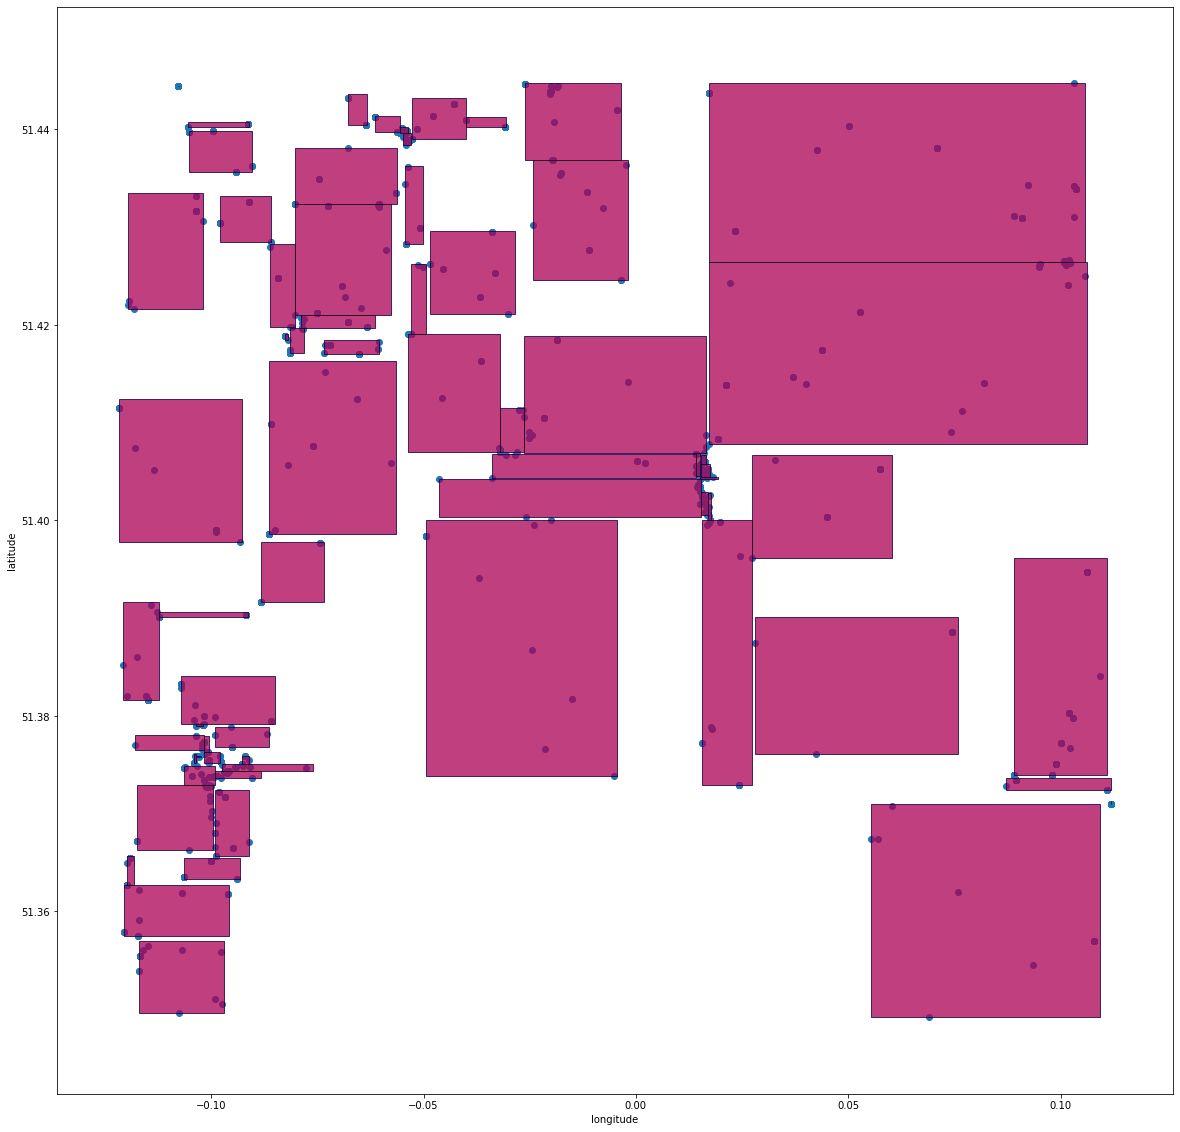

In [30]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

# Generating an k-Anonymous Dataset

In [31]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [32]:
#original code doesn not work
"""
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)
"""    

'\ndef build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):\n    aggregations = {}\n    for column in feature_columns:\n        if column in categorical:\n            aggregations[column] = agg_categorical_column\n        else:\n            aggregations[column] = agg_numerical_column\n    rows = []\n    for i, partition in enumerate(partitions):\n        if i % 100 == 1:\n            print("Finished {} partitions...".format(i))\n        if max_partitions is not None and i > max_partitions:\n            break\n        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)\n        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : \'count\'})\n        values = grouped_columns.iloc[0].to_dict()\n        for sensitive_value, count in sensitive_counts[sensitive_column].items():\n            if count == 0:\n                continue\n            values.update({\n                sensitive_column : s

In [33]:
#dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

In [34]:
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_KAnon =  pd.DataFrame(rows)

Finished 1 partitions...


In [35]:
df_KAnon

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
0,102317,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,2
1,102884,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,3
2,10657,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,5
3,10674,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,1
4,10683,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,3
...,...,...,...,...,...,...,...,...,...,...
622,4701,51.442041,-0.004450,2010,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,1
623,4900,51.442041,-0.004450,2010,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,2
624,55628,51.442041,-0.004450,2010,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,1
625,59977,51.442041,-0.004450,2010,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,1


In [36]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
df_KAnon.sort_values(feature_columns+[sensitive_column])

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
137,10670,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
138,120612,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
139,120895,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
140,129638,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
141,134843,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
...,...,...,...,...,...,...,...,...,...,...
123,726,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1
124,821,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
125,82458,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
126,83964,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1


In [37]:
from pandas import ExcelWriter
writer = ExcelWriter('df_KAnon.xlsx')
df_KAnon.to_excel(writer, encoding='utf8', index=False)
writer.save()

# Implementing l-diversity (the naive way)


In [38]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [39]:
# now let's apply this method to our data and see how the result changes
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [40]:
len(finished_l_diverse_partitions)

66

In [41]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

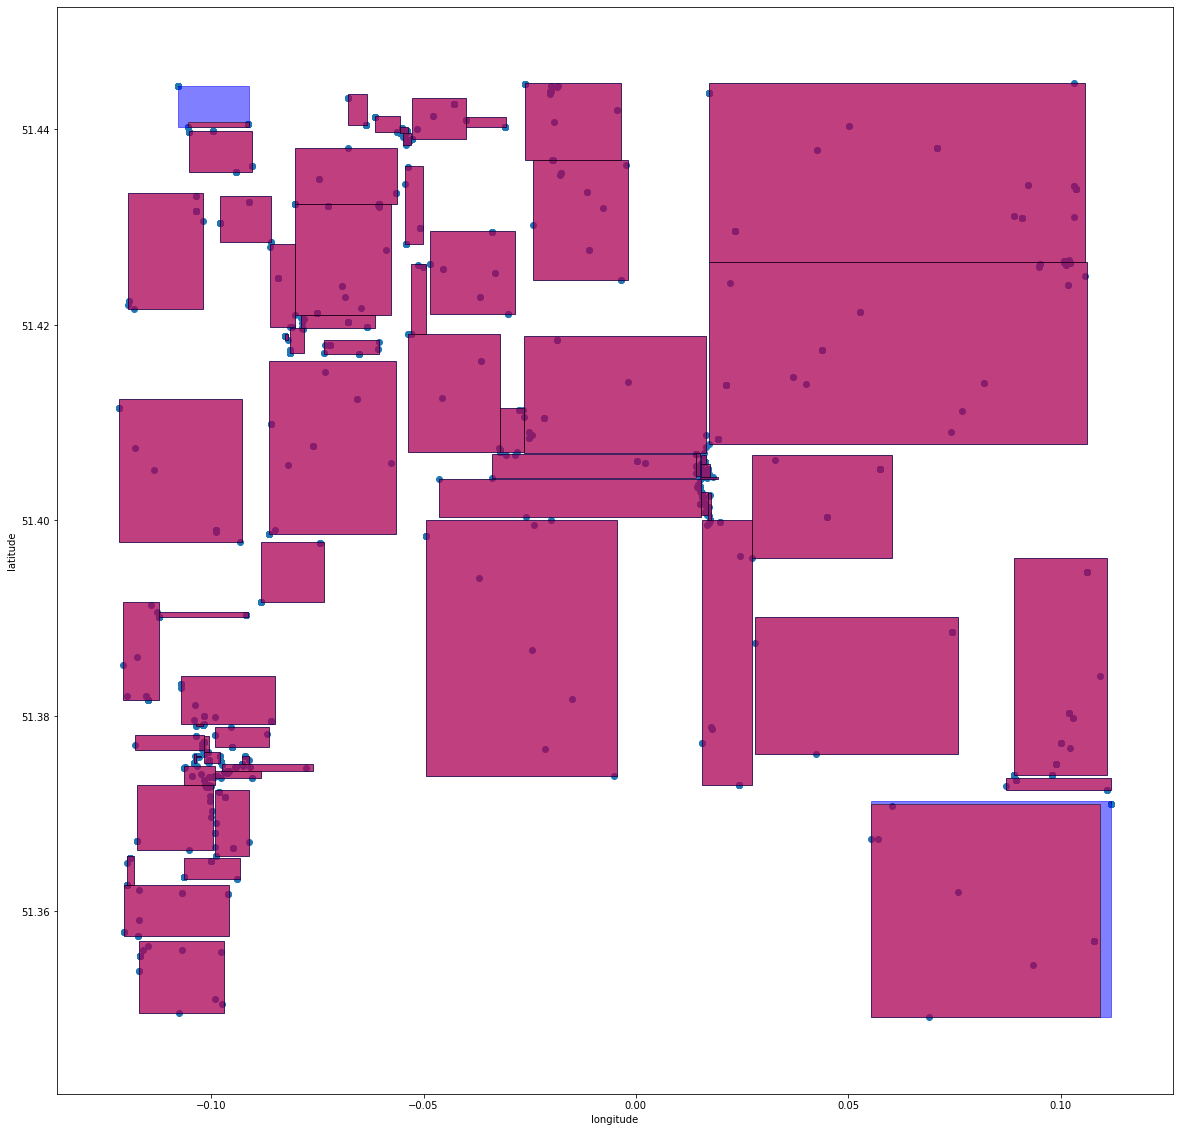

In [42]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [43]:
#dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_Idiversity =  pd.DataFrame(rows)

Finished 1 partitions...


In [44]:
# Let's see how l-diversity improves the anonymity of our dataset
df_Idiversity.sort_values([column_x, column_y, sensitive_column])

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
137,10670,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
138,120612,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
139,120895,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
140,129638,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
141,134843,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
...,...,...,...,...,...,...,...,...,...,...
123,726,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1
124,821,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
125,82458,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
126,83964,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1


In [45]:
from pandas import ExcelWriter
writer = ExcelWriter('df_Idiversity.xlsx')
df_Idiversity.to_excel(writer, encoding='utf8', index=False)
writer.save()

# Implementing t-closeness


In [46]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [47]:
global_freqs

{'100072': 0.0006609385327164573,
 '102317': 0.0013218770654329147,
 '102783': 0.0006609385327164573,
 '102884': 0.007270323859881031,
 '104953': 0.0019828155981493722,
 '10657': 0.003304692663582287,
 '10670': 0.0013218770654329147,
 '10674': 0.0006609385327164573,
 '10683': 0.0019828155981493722,
 '10698': 0.0006609385327164573,
 '10699': 0.0006609385327164573,
 '10708': 0.008592200925313946,
 '108090': 0.0006609385327164573,
 '10915': 0.0006609385327164573,
 '109226': 0.0006609385327164573,
 '109227': 0.0019828155981493722,
 '109232': 0.0006609385327164573,
 '109251': 0.006609385327164574,
 '109821': 0.0019828155981493722,
 '111294': 0.013218770654329148,
 '111926': 0.0013218770654329147,
 '112607': 0.0013218770654329147,
 '112927': 0.0013218770654329147,
 '113499': 0.0006609385327164573,
 '115326': 0.0006609385327164573,
 '11543': 0.0013218770654329147,
 '1170': 0.0006609385327164573,
 '117492': 0.005948446794448116,
 '117617': 0.0006609385327164573,
 '117619': 0.002643754130865829

In [48]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [49]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [50]:
len(finished_t_close_partitions)

11

In [51]:
#dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)
aggregations = {}
for column in feature_columns:
    if column in categorical:
        aggregations[column] = agg_categorical_column
    else:
        aggregations[column] = agg_numerical_column
rows = []
max_partitions=None
for i, partition in enumerate(finished_partitions):
    if i % 100 == 1:
        print("Finished {} partitions...".format(i))
    if max_partitions is not None and i > max_partitions:
        break
    grouped_columns = df.loc[partition]
    sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
    values = grouped_columns.iloc[0].to_dict()
    for sensitive_value, count in sensitive_counts[sensitive_column].items():
        if count == 0:
            continue
        values.update({
            sensitive_column : sensitive_value,
            'count' : count,

        })
        rows.append(values.copy())

df_tCloseness =  pd.DataFrame(rows)

Finished 1 partitions...


In [52]:
# Let's see how t-closeness fares
df_tCloseness.sort_values([column_x, column_y, sensitive_column])

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
137,10670,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
138,120612,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
139,120895,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,1
140,129638,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
141,134843,51.362754,-0.119697,2009,12,21,Tuesday,"Wing Yip, 544, Purley Way, Waddon, London Boro...",Wing Yip,2
...,...,...,...,...,...,...,...,...,...,...
123,726,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1
124,821,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
125,82458,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,2
126,83964,51.394768,0.106301,2010,9,15,Tuesday,"St Mary Cray, Furzehill Square, St Mary Cray, ...",St Mary Cray,1


In [53]:
from pandas import ExcelWriter
writer = ExcelWriter('df_tCloseness.xlsx')
df_tCloseness.to_excel(writer, encoding='utf8', index=False)
writer.save()

In [54]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

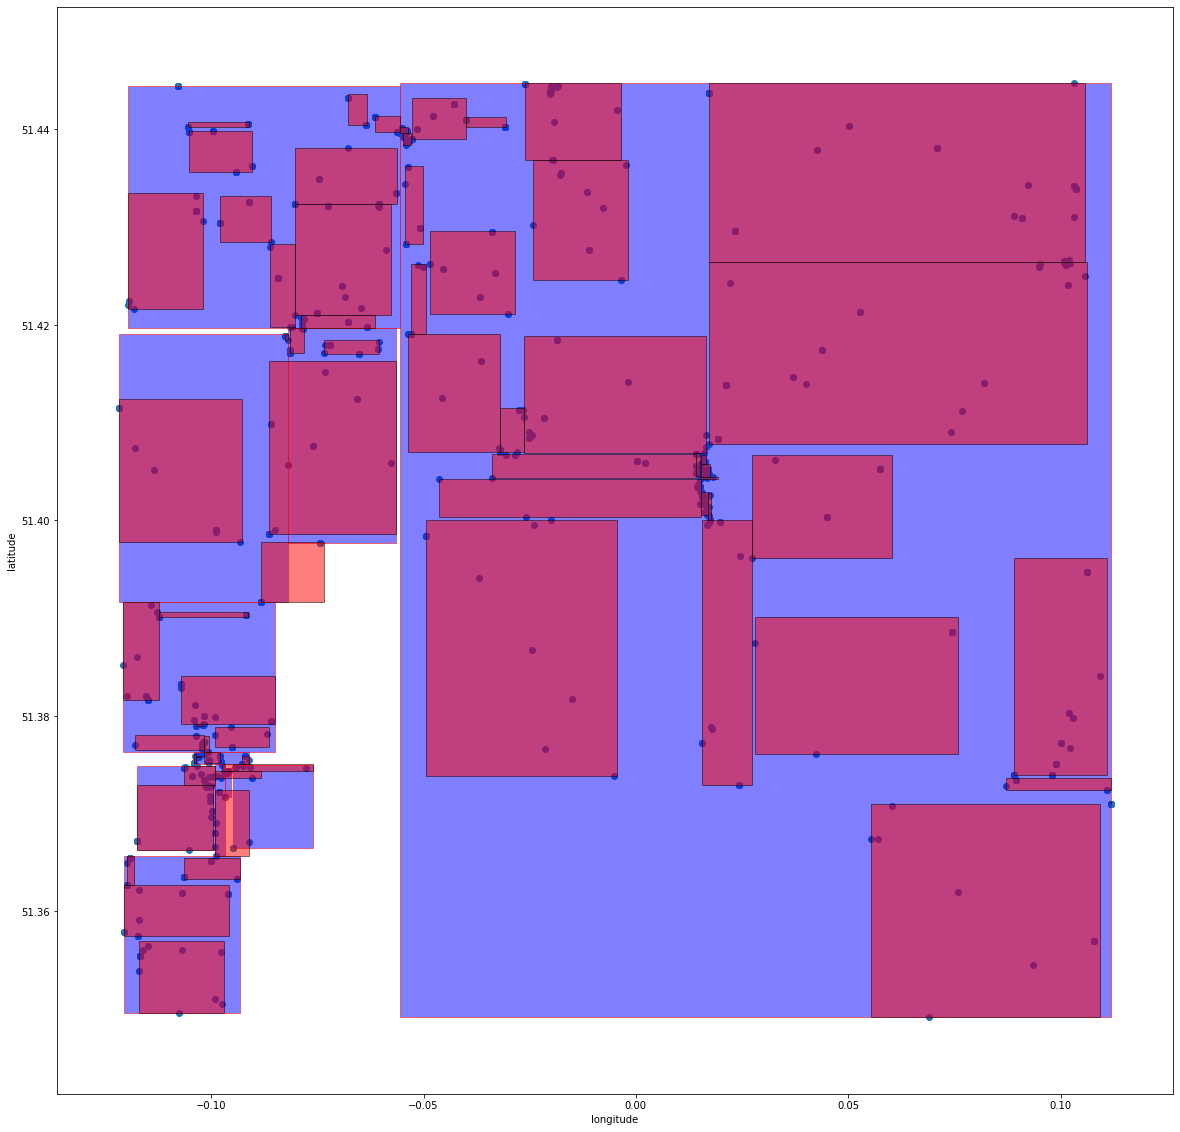

In [55]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='r', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

# Apply Regression on the original and k-annon datasets

In [56]:
#reimport from xls for Supervised
import pandas as pd
LondonCheckinsClss = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClss.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


In [57]:
# removing columns for Classification
LondonCheckinsClss = LondonCheckinsClss.drop(['location_id','check_in_time','checkin_Date'
                                              ,'checkin_time','checkin_year','checkin_day','latitude','longitude'
                                              ,'city_district','Location'
                                             # ,'checkin_month','checkin_weekday','checkin_hour','Address'
                                             # ,'latitude','longitude','user'
                                             ], axis=1)
LondonCheckinsClss.head(3)

,user,checkin_month,checkin_hour,checkin_weekday,Address
0,72,4,7,Sunday,"Sandhurst Road, Catford South, London Borough ..."
1,72,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B..."
2,72,4,16,Friday,"Centrale, Tamworth Road, Broad Green, London B..."


In [58]:
#one hot encoding for month and weekday 
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_month'], drop_first=True, prefix='month')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['checkin_hour'], drop_first=True, prefix='hour')
LondonCheckinsClss = pd.get_dummies(LondonCheckinsClss, columns=['Address'], drop_first=True, prefix='Address')
LondonCheckinsClss.head()

,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,"Address_West Norwood, Hannen Road, West Dulwich, West Norwood, London Borough of Lambeth, London, Greater London, England, SE27 0DT, United Kingdom","Address_West Wickham, Rays Road, West Wickham, London Borough of Bromley, London, Greater London, England, BR4 0EH, United Kingdom","Address_Whitgift Avenue, Haling Park Road, Waddon, London Borough of Croydon, London, Greater London, England, CR2 6NF, United Kingdom","Address_Whitgift Centre, Sydenham Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2YG, United Kingdom","Address_Widmore, London Borough of Bromley, London, Greater London, England, BR2 9PF, United Kingdom","Address_Wing Yip, 544, Purley Way, Waddon, London Borough of Croydon, London, Greater London, England, CR0 4RE, United Kingdom","Address_Woodland Road, London Borough of Lambeth, London, Greater London, England, SE19, United Kingdom","Address_York Avenue, Pound Place, Longlands, London Borough of Bexley, London, Greater London, England, DA15 7LJ, United Kingdom","Address_Zizzi, 11 - 13, Widmore Road, St Marks Square, Plaistow, London Borough of Bromley, London, Greater London, England, BR1 1RL, United Kingdom","Address_Zizzi, 57-59, South End, Waddon, London Borough of Croydon, London, Greater London, England, CR0 1BF, United Kingdom"
0,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, zero_one_loss

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    LondonCheckinsClss.drop('user', axis=1), LondonCheckinsClss['user'],
      test_size=0.33, random_state=2021)

In [61]:
NonPrivateClss = LogisticRegression(solver="lbfgs")
NonPrivateClss.fit(X_train, y_train)
NonPriv_pred_clss = NonPrivateClss.predict(X_test)
NonPriv_pred_train_clss = NonPrivateClss.predict(X_train)
clss_error = zero_one_loss(y_test, NonPriv_pred_clss)

print("Training set score: %.2f%%" % (NonPrivateClss.score(X_train, y_train) * 100))
print("Test set score: %.2f%%" % (NonPrivateClss.score(X_test, y_test) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 75.62%
Test set score: 52.60%
Error: 47.40%



## Applying Log Regression on the K-Annonymous data

In [62]:
df_KAnonymity = df_KAnon.copy()
df_KAnonymity.head(2)

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
0,102317,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,2
1,102884,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,3


In [63]:
df_KAnonymity = df_KAnonymity.drop(['Location','count','longitude','latitude','checkin_year'], axis=1)
df_KAnonymity.head(3)

,user,checkin_month,checkin_hour,checkin_weekday,Address
0,102317,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."
1,102884,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."
2,10657,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."


In [64]:
#one hot encoding for month and weekday 
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_month'], drop_first=True, prefix='month')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_KAnonymity = pd.get_dummies(df_KAnonymity, columns=['Address'], drop_first=True, prefix='Address')
df_KAnonymity.head()

,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,"Address_The Compass, Widmore Road, St Marks Square, Plaistow, London Borough of Bromley, London, Greater London, England, BR2, United Kingdom","Address_The Crystal Palace Market, 3-7, Church Road, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 2TF, United Kingdom","Address_The George, Wortley Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 3QB, United Kingdom","Address_Timur, 17, Westow Street, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 3RY, United Kingdom","Address_Tulse Hill Station ticket office, Station Rise, Tulse Hill, London Borough of Lambeth, London, Greater London, England, SE27 9BQ, United Kingdom","Address_Waddon Marsh, Drury Crescent, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 4XT, United Kingdom","Address_West Croydon, Station Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2RB, United Kingdom","Address_Whitgift Centre, Sydenham Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2YG, United Kingdom","Address_Wing Yip, 544, Purley Way, Waddon, London Borough of Croydon, London, Greater London, England, CR0 4RE, United Kingdom","Address_Zizzi, 57-59, South End, Waddon, London Borough of Croydon, London, Greater London, England, CR0 1BF, United Kingdom"
0,102317,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,102884,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,10657,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10674,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10683,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainK, X_testK, y_trainK, y_testK = train_test_split(
    df_KAnonymity.drop('user', axis=1), df_KAnonymity['user'],
      test_size=0.33, random_state=2021)

In [66]:
KAnonClss = LogisticRegression()
KAnonClss.fit(X_trainK, y_trainK)
KAnon_pred_clss = KAnonClss.predict(X_testK)
KAnon_pred_train_clss = KAnonClss.predict(X_trainK)
clss_error = zero_one_loss(y_testK, KAnon_pred_clss)

print("Training set score: %.2f%%" % (KAnonClss.score(X_trainK, y_trainK) * 100))
print("Test set score: %.2f%%" % (KAnonClss.score(X_testK, y_testK) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 14.76%
Test set score: 2.42%
Error: 97.58%



## Applying Log Regression on t-closeness dataset

In [67]:
df_tClose = df_tCloseness.copy()
df_tClose.head(2)

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
0,102317,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,2
1,102884,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,3


In [68]:
df_tClose = df_tClose.drop(['Location','count','longitude','latitude','checkin_year'], axis=1)
df_tClose.head(3)

,user,checkin_month,checkin_hour,checkin_weekday,Address
0,102317,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."
1,102884,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."
2,10657,10,5,Monday,"East Croydon, George Street, Broad Green, Lond..."


In [69]:
#one hot encoding for month and weekday 
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_month'], drop_first=True, prefix='month')
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_tClose = pd.get_dummies(df_tClose, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_tClose = pd.get_dummies(df_tClose, columns=['Address'], drop_first=True, prefix='Address')
df_tClose.head()

,user,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,"Address_The Compass, Widmore Road, St Marks Square, Plaistow, London Borough of Bromley, London, Greater London, England, BR2, United Kingdom","Address_The Crystal Palace Market, 3-7, Church Road, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 2TF, United Kingdom","Address_The George, Wortley Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 3QB, United Kingdom","Address_Timur, 17, Westow Street, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 3RY, United Kingdom","Address_Tulse Hill Station ticket office, Station Rise, Tulse Hill, London Borough of Lambeth, London, Greater London, England, SE27 9BQ, United Kingdom","Address_Waddon Marsh, Drury Crescent, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 4XT, United Kingdom","Address_West Croydon, Station Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2RB, United Kingdom","Address_Whitgift Centre, Sydenham Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2YG, United Kingdom","Address_Wing Yip, 544, Purley Way, Waddon, London Borough of Croydon, London, Greater London, England, CR0 4RE, United Kingdom","Address_Zizzi, 57-59, South End, Waddon, London Borough of Croydon, London, Greater London, England, CR0 1BF, United Kingdom"
0,102317,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,102884,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,10657,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10674,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10683,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [70]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainT, X_testT, y_trainT, y_testT = train_test_split(
    df_tClose.drop('user', axis=1), df_tClose['user'],
      test_size=0.33, random_state=2021)

In [71]:
tCloseClss = LogisticRegression()
tCloseClss.fit(X_trainT, y_trainT)
tClose_pred_clss = tCloseClss.predict(X_testT)
tClose_pred_train_clss = tCloseClss.predict(X_trainT)
clss_error = zero_one_loss(y_testT, tClose_pred_clss)

print("Training set score: %.2f%%" % (tCloseClss.score(X_trainT, y_trainT) * 100))
print("Test set score: %.2f%%" % (tCloseClss.score(X_testT, y_testT) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))

Training set score: 14.76%
Test set score: 2.42%
Error: 97.58%



## Applying Log Regression on the K-Anon I-Diversity data

In [72]:
df_Idiverse = df_Idiversity.copy()
df_Idiverse.head(2)

,user,latitude,longitude,checkin_year,checkin_month,checkin_hour,checkin_weekday,Address,Location,count
0,102317,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,2
1,102884,51.375049,-0.092794,2010,10,5,Monday,"East Croydon, George Street, Broad Green, Lond...",East Croydon,3


In [73]:
#one hot encoding for month and weekday 
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_month'], drop_first=True, prefix='month')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_weekday'], drop_first=True, prefix='wkday')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['checkin_hour'], drop_first=True, prefix='hour')
df_Idiverse = pd.get_dummies(df_Idiverse, columns=['Address'], drop_first=True, prefix='Address')
df_Idiverse.head()

,user,latitude,longitude,checkin_year,Location,count,month_2,month_3,month_4,month_5,...,"Address_The Compass, Widmore Road, St Marks Square, Plaistow, London Borough of Bromley, London, Greater London, England, BR2, United Kingdom","Address_The Crystal Palace Market, 3-7, Church Road, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 2TF, United Kingdom","Address_The George, Wortley Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 3QB, United Kingdom","Address_Timur, 17, Westow Street, Upper Norwood, London Borough of Croydon, London, Greater London, England, SE19 3RY, United Kingdom","Address_Tulse Hill Station ticket office, Station Rise, Tulse Hill, London Borough of Lambeth, London, Greater London, England, SE27 9BQ, United Kingdom","Address_Waddon Marsh, Drury Crescent, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 4XT, United Kingdom","Address_West Croydon, Station Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2RB, United Kingdom","Address_Whitgift Centre, Sydenham Road, Broad Green, London Borough of Croydon, London, Greater London, England, CR0 2YG, United Kingdom","Address_Wing Yip, 544, Purley Way, Waddon, London Borough of Croydon, London, Greater London, England, CR0 4RE, United Kingdom","Address_Zizzi, 57-59, South End, Waddon, London Borough of Croydon, London, Greater London, England, CR0 1BF, United Kingdom"
0,102317,51.375049,-0.092794,2010,East Croydon,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,102884,51.375049,-0.092794,2010,East Croydon,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10657,51.375049,-0.092794,2010,East Croydon,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10674,51.375049,-0.092794,2010,East Croydon,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10683,51.375049,-0.092794,2010,East Croydon,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
import numpy as np
from sklearn.model_selection import train_test_split
X_trainD, X_testD, y_trainD, y_testD = train_test_split(
    df_Idiverse.drop('user', axis=1), df_Idiverse['user'],
      test_size=0.33, random_state=2021)

In [75]:
tCloseClss = LogisticRegression()
tCloseClss.fit(X_trainT, y_trainT)
tClose_pred_clss = tCloseClss.predict(X_testT)
tClose_pred_train_clss = tCloseClss.predict(X_trainT)
clss_error = zero_one_loss(y_testT, tClose_pred_clss)

print("Training set score: %.2f%%" % (tCloseClss.score(X_trainT, y_trainT) * 100))
print("Test set score: %.2f%%" % (tCloseClss.score(X_testT, y_testT) * 100))
print("Error: %.2f%%" % ((clss_error) * 100))


Training set score: 14.76%
Test set score: 2.42%
Error: 97.58%
